# TVA

In [1]:
import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.outcomes import plurality_outcome
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
import os

In [2]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

This is the voting input

In [3]:
voting = utils.read_voting(path_voting, table_name="voting5")
voting_table = voting.to_pandas()
voting_table

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


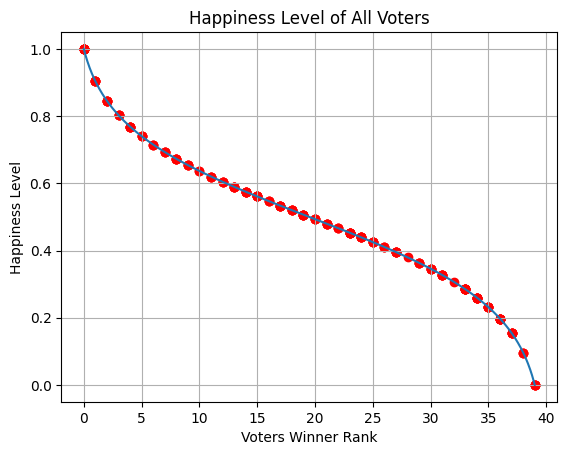

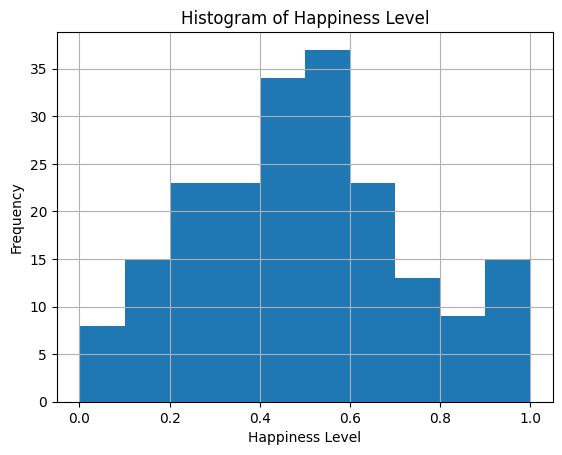

In [4]:
random_voting = utils.random_voting(200, 40)

result_random = plurality_outcome(random_voting)
happiness_level = HappinessLevel(random_voting, result_random.winner)
happiness_level.plot()
happiness_level.histogram()

## Strategic Voting

In [5]:
voting.to_pandas()

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


In [6]:
result = plurality_outcome(voting)
result

Winner: C
{'A': 1, 'B': 2, 'C': 3, 'D': 0}

Note that **voter 5** is the only voter that can engage in strategic voting. Voter 5 prefers $B$ over the winner $C$. Hence, they can increase their $\text{Happiness Level}$ by placing $B$ as their first preference, resulting in a tie between $C$ and $B$ in the voting outcome (for plurality, voting for two, Borda). Since ties are resolved in alphabetical order, $B$ wins over $C$.

The table below displays the two voting strategies available to voter 5.

In [8]:

happiness_level = HappinessLevel(voting, result.winner)
strategic_voting = StrategicVoting(voting)
strategic_voting.find(happiness_level, plurality_outcome)

strategic_voting.all

,voter,strategic_voting,new_result,strategic_H,previous_H,stategic_overall_H,startegic_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487
1,5,"[B, D, A, C]",B,0.410487,0.0,2.820973,3.410487
